In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import glob

from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import seaborn as sns

2025-10-01 08:16:10.089071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759306570.325243      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759306570.394885      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

## Build a DataFrame containing image paths, mask status labels, and dataset split (train/test/val)

In [3]:

dataset = {
    "image_path": [],
    "mask_status": [],
    "which": []
}

for which in os.listdir(path):
    for status in os.listdir(path+"/"+which):
        for image in glob.glob(path+which+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["which"].append(which)
            
dataset = pd.DataFrame(dataset)
dataset.head()



,image_path,mask_status,which
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation


## Visualizing the dataset distribution

With Mask: 5909
Without Mask: 5883


/tmp/ipykernel_19/2124583532.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"With Mask:", dataset.value_counts("mask_status")[0])
/tmp/ipykernel_19/2124583532.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Without Mask:", dataset.value_counts("mask_status")[1])


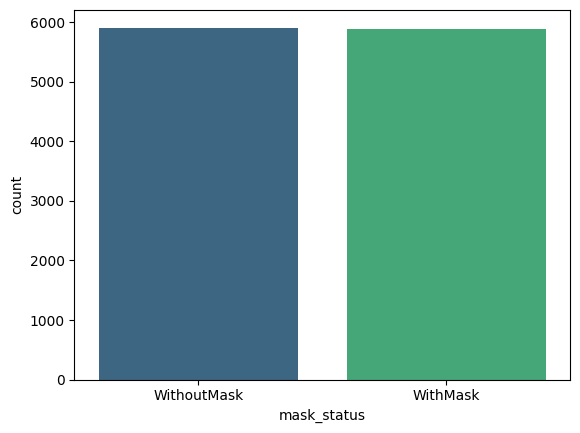

In [4]:
# Checking for the total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])
sns.countplot(x = dataset["mask_status"], palette="viridis")  
plt.show()

## Visualizing random images from dataset

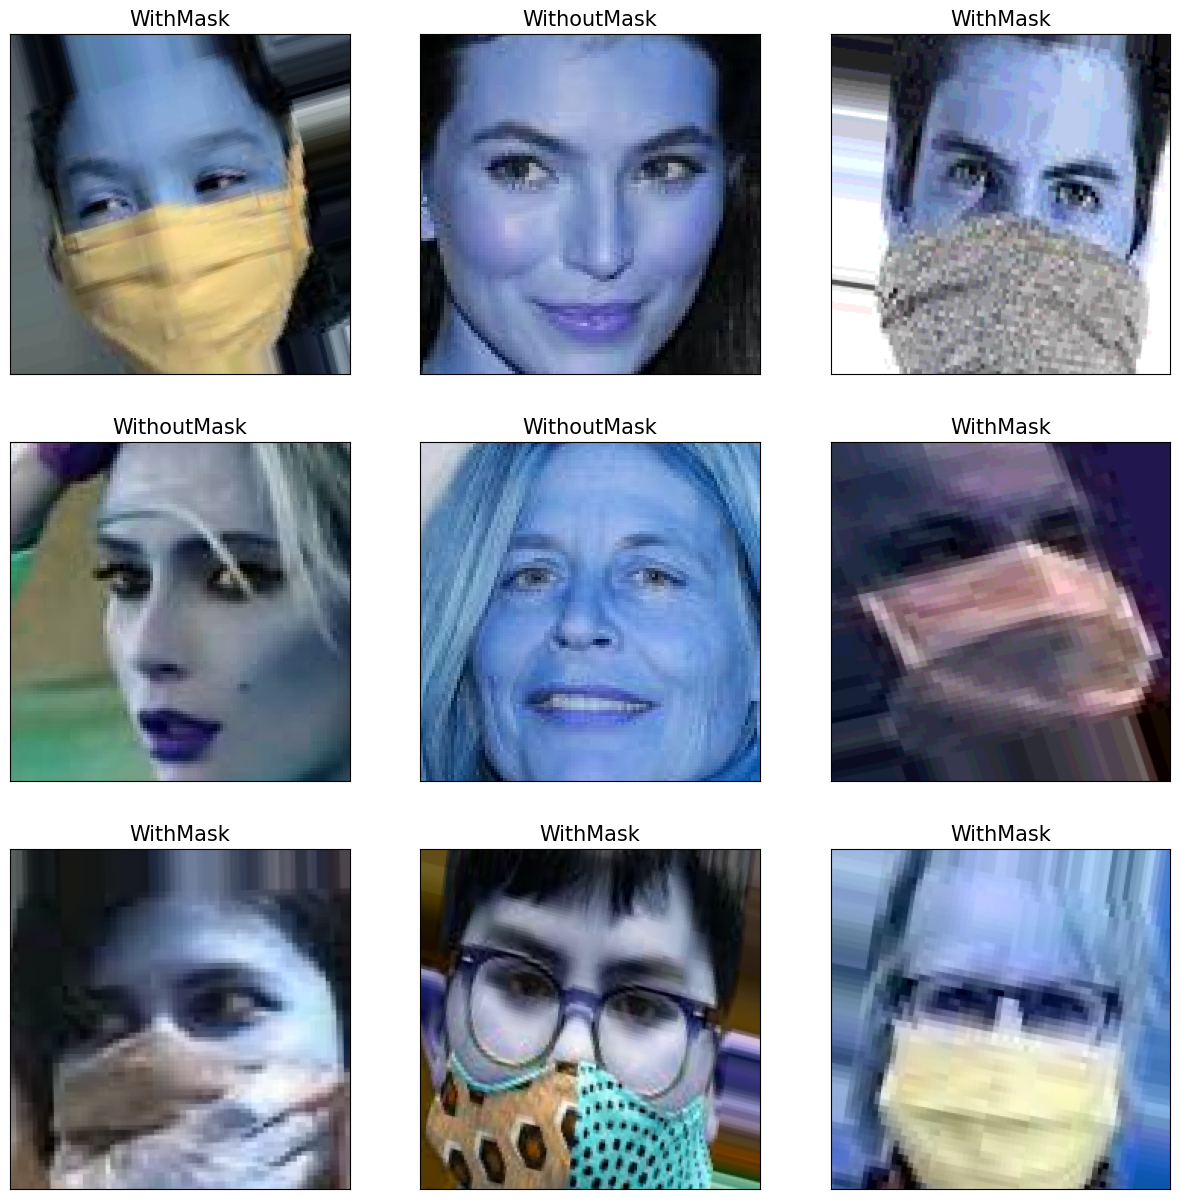

In [5]:


plt.figure(figsize = (15, 15))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()


## Face Detection using Haarcascade Algorithm

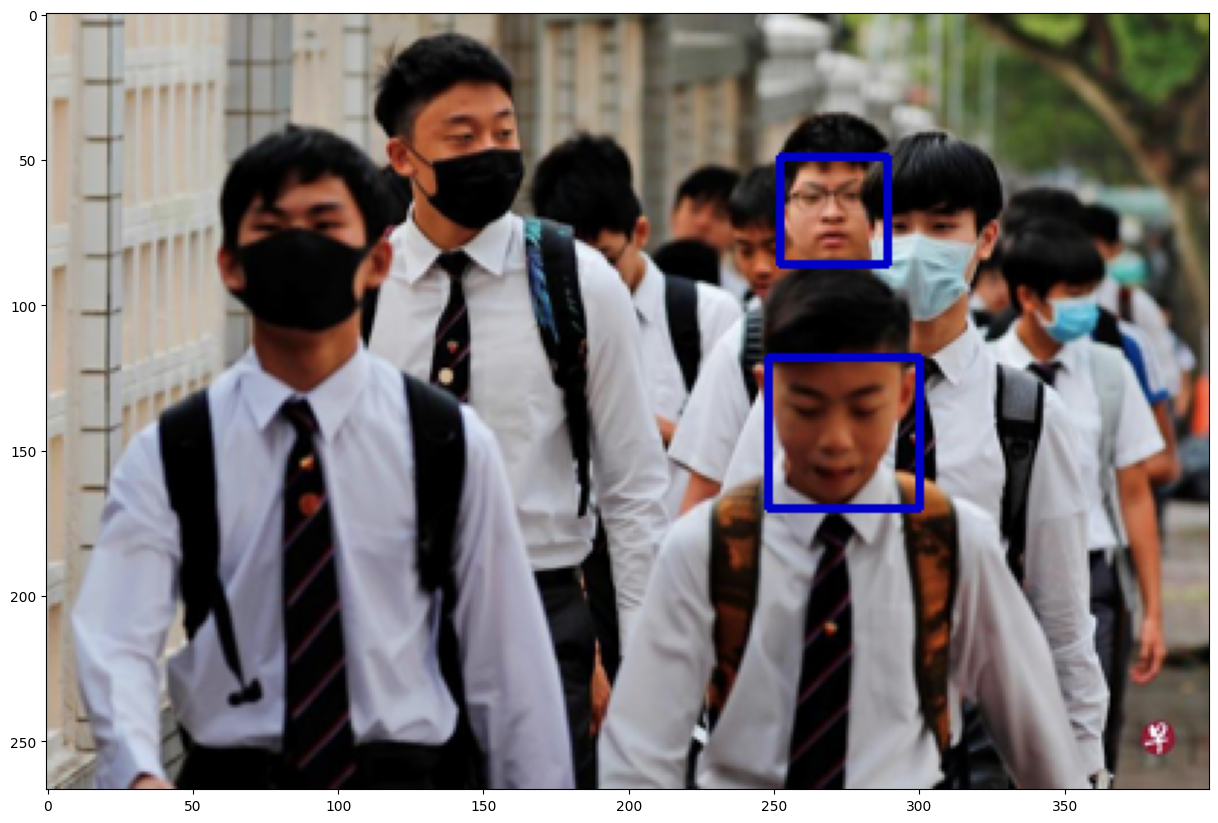

In [6]:

# Load pre-trained Haar Cascade for face detection
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Read image
img = cv2.imread("../input/face-mask-detection/images/maksssksksss131.png")

# Converting the image to grayscale 
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img)

# grayscale to colored image
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Drawing rectangle box around the faces 
for (x, y, w, h) in detected_face:
    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0, 0, 200), 2)
    
#Displaying the image
plt.figure(figsize = (15, 15))
plt.imshow(output_img)


## Spliting Train, Test and Validation Dataset

In [7]:
train_df = dataset[dataset["which"] == "Train"]
test_df = dataset[dataset["which"] == "Test"]
valid_df = dataset[dataset["which"] == "Validation"]

print(train_df.head())

                                             image_path  mask_status  which
1792  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1793  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1794  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1795  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1796  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train


## Shuffle each split

In [8]:

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
valid_df = valid_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(train_df.head())



                                          image_path  mask_status  which
0  ../input/face-mask-12k-images-dataset/Face Mas...     WithMask  Train
1  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
2  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
3  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
4  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train


## Distribution of dataset splits (Train/Test/Validation)

mask_status  WithMask  WithoutMask
which                             
Test              483          509
Train            5000         5000
Validation        400          400


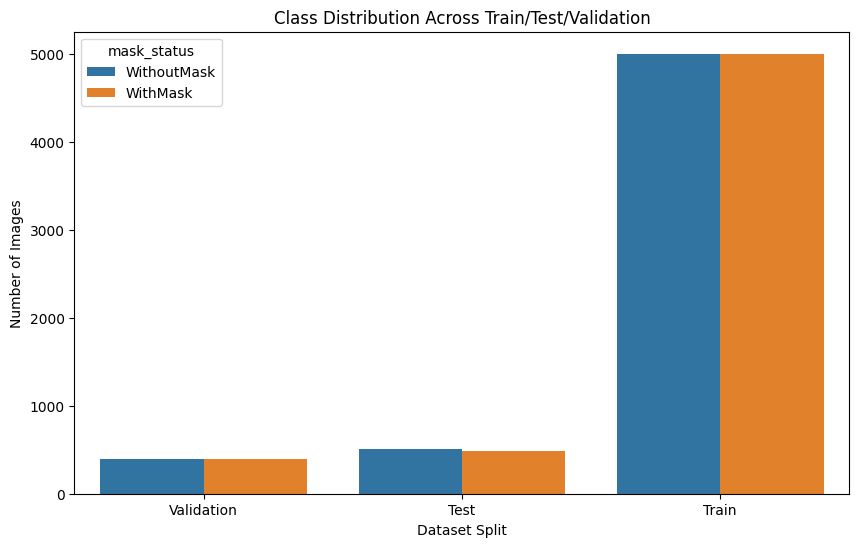

In [9]:

counts = dataset.groupby(["which", "mask_status"]).size().unstack(fill_value=0)
print(counts)

plt.figure(figsize=(10,6))
sns.countplot(x="which", hue="mask_status", data=dataset)
plt.title("Class Distribution Across Train/Test/Validation")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.show()


## Preprocessing the images

In [10]:
IMG_SIZE = 150
label_map = {"WithMask": 0, "WithoutMask": 1}

def preprocess_images(df):
    X = []
    y = []
    for idx, row in df.iterrows():
        img = cv2.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0
        X.append(img)
        y.append(label_map[row["mask_status"]])
    X = np.array(X, dtype="float32")
    y = np.array(y)
    return X, y


# Preprocess all datasets
X_train, y_train = preprocess_images(train_df)
X_valid, y_valid = preprocess_images(valid_df)
X_test, y_test = preprocess_images(test_df)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_valid_cat = to_categorical(y_valid, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

## Builds a CNN with two Conv2D layers, Dropout, and Dense layers.

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(100, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(100, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759306740.988738      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15257 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 100)    │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     6,480,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,573,052 (25.07 MB)

 Trainable params: 6,573,052 (25.07 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [12]:

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1759306750.838018      72 service.cc:148] XLA service 0x7a7a4c0a2740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759306750.839084      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759306751.112746      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5275 - loss: 2.3967

I0000 00:00:1759306755.125731      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8290 - loss: 0.4915 - val_accuracy: 0.9837 - val_loss: 0.0568
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9748 - loss: 0.0619 - val_accuracy: 0.9900 - val_loss: 0.0328
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9858 - loss: 0.0398 - val_accuracy: 0.9912 - val_loss: 0.0205
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9843 - loss: 0.0425 - val_accuracy: 0.9912 - val_loss: 0.0262
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9868 - loss: 0.0314 - val_accuracy: 0.9825 - val_loss: 0.0554
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9895 - loss: 0.0283 - val_accuracy: 0.9875 - val_loss: 0.0322
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9904 - loss: 0.0252 - val_accuracy: 0.9937 - val_loss: 0.0209
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.9950 - loss: 0.0143 - val_accuracy: 0.98

## Plot Loss Curve

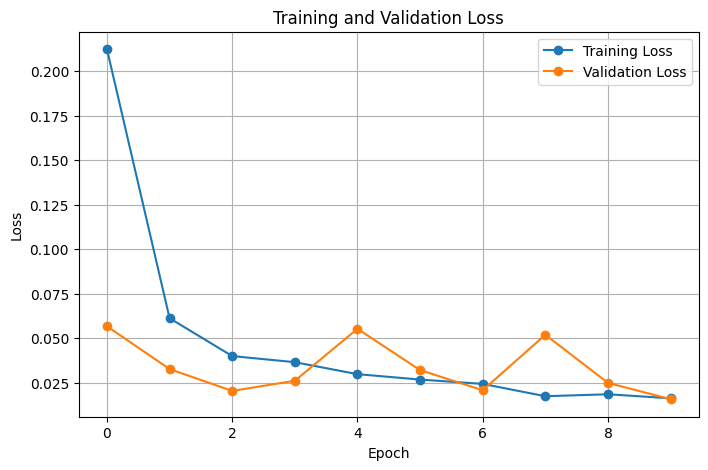

In [13]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Plot Accuracy Curve

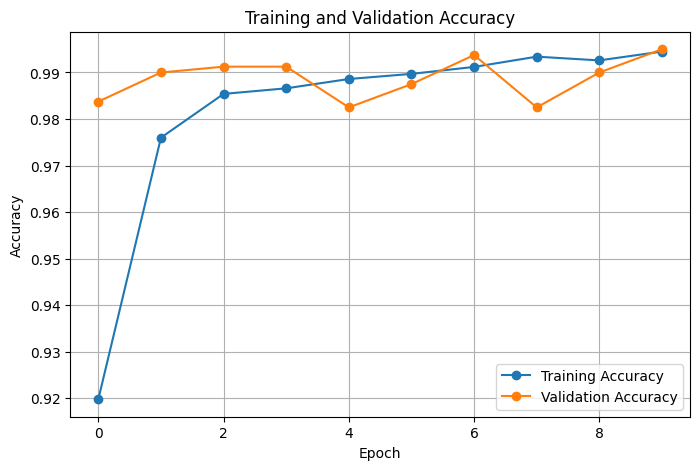

In [14]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate on Test Set

In [15]:

test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc*100:.2f}%")



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9841 - loss: 0.0632
Test Accuracy: 98.69%


##  Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


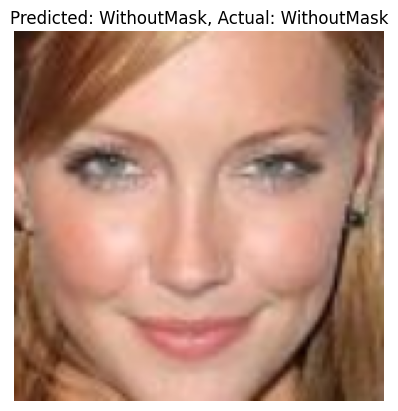

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


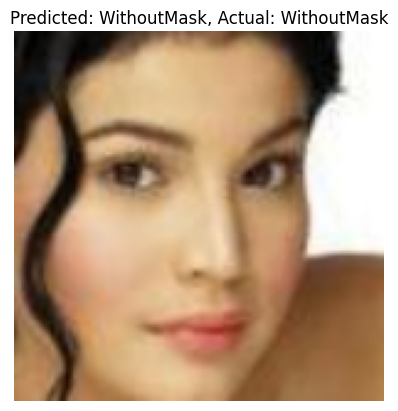

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


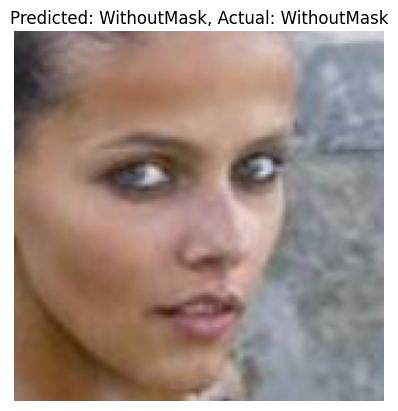

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


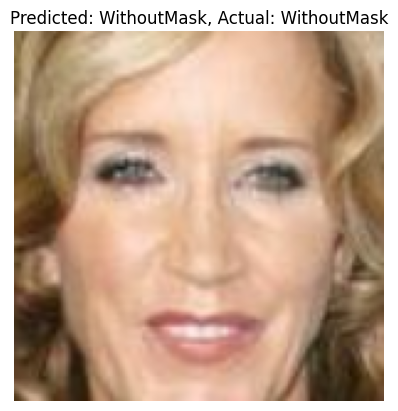

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


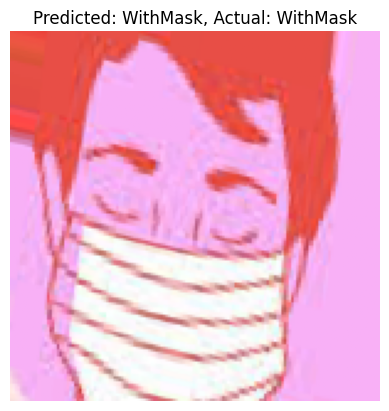

In [16]:
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx]
    pred = np.argmax(model.predict(img[np.newaxis, ...]), axis=1)[0]
    label = "WithMask" if pred == 0 else "WithoutMask"
    plt.imshow(img)
    plt.title(f"Predicted: {label}, Actual: {list(label_map.keys())[y_test[idx]]}")
    plt.axis('off')
    plt.show()